In [1]:
import os
import sys
sys.path.append("../")
sys.path.append("../REDPAN_tools")
import logging
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy
from glob import glob
from obspy import read
from model_loader import redpan_picker
from REDPAN_picker import extract_picks
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s : %(asctime)s : %(message)s"
)

2023-09-04 15:53:24.951877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-04 15:53:24.951939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-04 15:53:24.952025: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 15:53:24.965905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


## Load the encapsulated RED-PAN API

In [2]:
### Model selection. 
# Please make sure the model (absolute/relative) path is correct.
# assign ${mdl_hdr} with "REDPAN_30s" or "REDPAN_60s"
# REDPAN_30s: model of 30-second-long receptive field
# REDPAN_60s: model of 60-second-long receptive field
mdl_hdr = "REDPAN_60s" # assign with "REDPAN_30s" or "REDPAN_60s"
model_path = f"../pretrained_model/{mdl_hdr}"

### prediction parameters and information
# delta, we use broadband seismometers with sample rate of 100 Hz
dt = 0.01
# sliding window length for making predictions
pred_interval_sec = 5
# set `bandpass=None` to disable waveform bandpass filtering
bandpass = [5, 45]
# Post-processing configurations. 
# This only preserve the thresholded values. Others are filled with zeros.
postprocess_config = {
    "mask_trigger": [0.3, 0.3], # trg_on and trg_off threshold
    "mask_len_thre": 0.5, # minimum length of mask in seconds
    "mask_err_win": 0.5, # potential window in seconds for mask error
    "detection_threshold": 0.5, # detection threshold for mask
    "P_threshold": 0.3, # detection threshold for P
    "S_threshold": 0.3 # detection threshold for S
}

### load the encapsulated RED-PAN API
# set postprocess_config=None to disable postprocessing
picker, pred_npts = redpan_picker(
    model_path=model_path, 
    pred_interval_sec=pred_interval_sec,
    dt=dt,
    postprocess_config=postprocess_config
)

2023-09-04 15:53:27.941114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1833] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7693 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Loaded PhasePicker: REDPAN_60s
Model path: /home/rick/Desktop/RED-PAN/pretrained_model/REDPAN_60s


## The picker can adapt waveforms in any length

### Make predictions on the waveform shorter than model receptive field

2023-09-04 15:53:33.241778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8801


1 Trace(s) in Stream:
BW.RJOB..redpan_P | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_S | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_mask | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


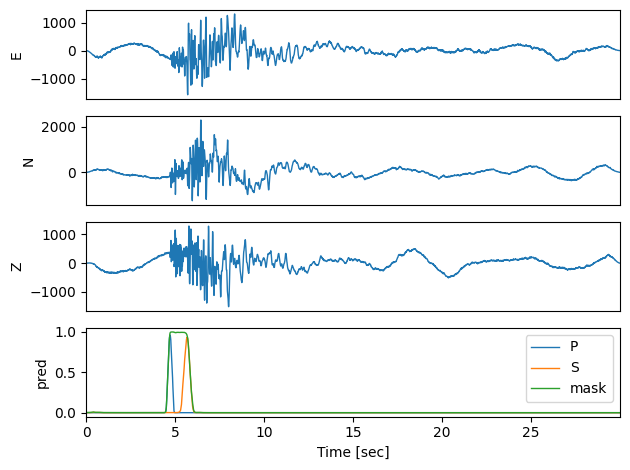

In [3]:
# read the default waveform from obspy, which is 30-second-long
wf1 = read(); wf1.sort()
# the redpan_picker function will complement the waveform to fulfill the length that the model needs
P_stream, S_stream, M_stream = picker.annotate_stream(wf1)
print(P_stream)
print(S_stream)
print(M_stream)
# plot the predictions
fig, ax = plt.subplots(4, 1)
x = np.arange(len(wf1[0].data))*0.01
x_data = [wf1[0].data, wf1[1].data, wf1[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    
ax[3].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[3].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

### Make predictions on the waveform longer than model receptive field using Seismogram-Tracking Median Filter (STMF) strategy

12/12 [==============================] - 7s 63ms/step


/home/rick/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rick/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12/12 [==============================] - 1s 42ms/step
1 Trace(s) in Stream:
CI.CLC..redpan_P | 2019-07-04T16:49:59.997986Z - 2019-07-04T17:19:59.997986Z | 100.0 Hz, 180001 samples
1 Trace(s) in Stream:
CI.CLC..redpan_S | 2019-07-04T16:49:59.997986Z - 2019-07-04T17:19:59.997986Z | 100.0 Hz, 180001 samples
1 Trace(s) in Stream:
CI.CLC..redpan_mask | 2019-07-04T16:49:59.997986Z - 2019-07-04T17:19:59.997986Z | 100.0 Hz, 180001 samples


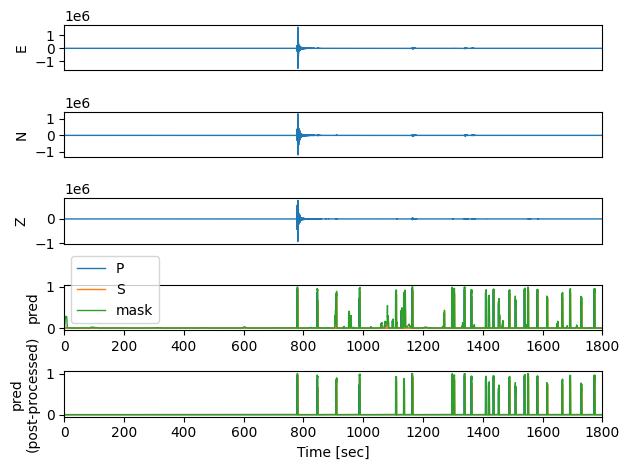

77836 [78114, 0.9791480778790206, 77847, 0.9617085456848145, 78098, 0.9581630229949951]
2019-07-04T16:49:59.997986Z 2019-07-04T17:02:58.467986Z 2019-07-04T17:03:00.977986Z
84561 [84834, 0.9025625359444391, 84572, 0.8750517964363098, 84821, 0.6665738821029663]
2019-07-04T16:49:59.997986Z 2019-07-04T17:04:05.717986Z 2019-07-04T17:04:08.207986Z
90835 [91111, 0.7924311655587044, 90844, 0.7054669857025146, 91096, 0.8284519910812378]
2019-07-04T16:49:59.997986Z 2019-07-04T17:05:08.437986Z 2019-07-04T17:05:10.957986Z
98624 [98961, 0.950861600810767, 98635, 0.7325588464736938, 98946, 0.8914672136306763]
2019-07-04T16:49:59.997986Z 2019-07-04T17:06:26.347986Z 2019-07-04T17:06:29.457986Z
110831 [111120, 0.7988568989875819, 110843, 0.788699209690094, 111104, 0.8236035108566284]
2019-07-04T16:49:59.997986Z 2019-07-04T17:08:28.427986Z 2019-07-04T17:08:31.037986Z
113507 [113776, 0.8121989187697939, 113518, 0.7246283292770386, 113765, 0.6197104454040527]
2019-07-04T16:49:59.997986Z 2019-07-04T17:08:5

In [4]:
# read the default waveform from obspy, which is 30-second-long
wf2 = read('../temp_03_continuous_predict/Ridgecrest_WFs/2019.185.17/*CLC*')
wf2.sort()
# slice the waveform into 30-minutes long
stt = wf2[0].stats.starttime
ent = stt + 1800
wf2 = wf2.slice(stt, ent)
# the redpan_picker function will complement the waveform to fulfill the length that the model needs
# without post-process
P_stream, S_stream, M_stream = picker.annotate_stream(wf2)
# with post-process
P_stream_post, S_stream_post, M_stream_post = picker.annotate_stream(wf2, postprocess=True)
print(P_stream)
print(S_stream)
print(M_stream)

# plot the predictions
fig, ax = plt.subplots(5, 1)
x = np.arange(len(P_stream[0].data))*0.01
x_data = [wf2[0].data, wf2[1].data, wf2[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
pred_post_data = [P_stream_post[0].data, S_stream_post[0].data, M_stream_post[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    ax[4].plot(x, pred_post_data[i], linewidth=1, label=pred_label[i])
    
ax[3].set_xlim(x.min(), x.max())
ax[4].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[4].set_ylabel('pred\n(post-processed)')
ax[4].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

# extract pick and convert to pandas.DataFrame object
pick_df = extract_picks(
    wf2, 
    P_stream_post, 
    S_stream_post, 
    M_stream_post, 
    dt=0.01,
    p_amp_estimate_sec=1, 
    s_amp_estimate_sec=3,
    args={"detection_threshold":0.5, "P_threshold":0.3, "S_threshold":0.3}
)
print(pick_df)